In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

In [3]:
def PCA_soil_rotated(file_name, code, temporal_limits,n_components_sst=40, missing_value=0):
    sst = Data(file_name,code,temporal_limits, missing_value= missing_value)

    result = sst.get_data()
    lon_sst_list = sst.get_lon_list()
    lat_sst_list = sst.get_lat_list()
    lon = sst.get_lon()
    lat = sst.get_lat()
    
    lons = np.arange(lon[0],lon[-1],2)
    lats = np.arange(lat[0],lat[-1],-2)

    INDEX = []
    for i in range(len(lon_sst_list)):
        if (lon_sst_list[i] in lons) and (lat_sst_list[i] in lats):
            INDEX.append(i)
    
    result = result[:,INDEX]
    lat_sst_list = np.array(lat_sst_list)[INDEX]
    lon_sst_list = np.array(lon_sst_list)[INDEX]

    result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
    result_sst = signal.detrend(result_sst, axis=0)
    weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
    for i in range(len(weights)):
        result_sst[:,i] = weights[i] * result_sst[:,i]

    data_sst = pd.DataFrame(result_sst)
        
    V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)
        
    Vr, Rot = rung.varimax(V)
    Vr = rung.svd_flip(Vr)

    # Get explained variance of rotated components
    s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

    # matrix with diagonal containing variances of rotated components
    S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
    expvar = np.diag(S2r)

    sorted_expvar = np.sort(expvar)[::-1]
    # s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

    # reorder all elements according to explained variance (descending)
    nord = np.argsort(expvar)[::-1]
    Vr = Vr[:, nord]

    # Get time series of UNMASKED data
    comps_ts = np.matmul(np.array(data_sst),Vr)

    df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

    lon_temp = df_sst["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df_sst["lons"].vlues = lon_temp
    
    return(result_sst, comps_ts, Vr, df_sst, avgs, stds)

In [6]:
train_start = 1966
validation_end = 2005
n_components_soil = 44
f = 12
tau = 3
cc = "ET"

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}

In [7]:
data_sst, ts, Vr, df_sst, avg, std = PCA_soil_rotated('../../../nc/soilw.mon.mean.v2.nc',"soilw",temporal_limits)

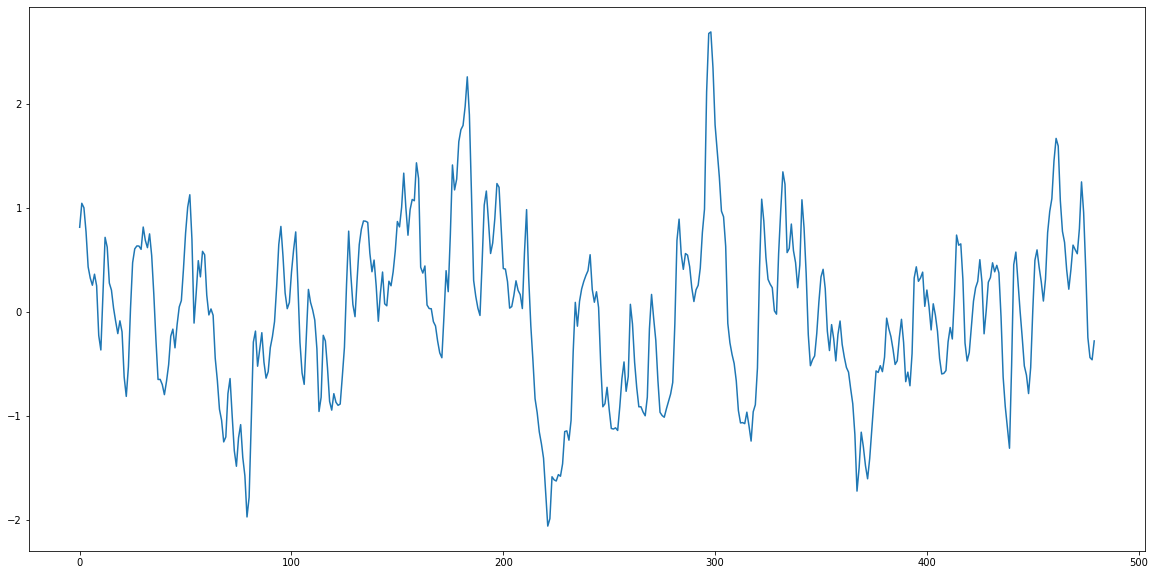

In [11]:
plt.plot(data_sst[:,1000])

In [12]:
data = data_sst[:,1000]

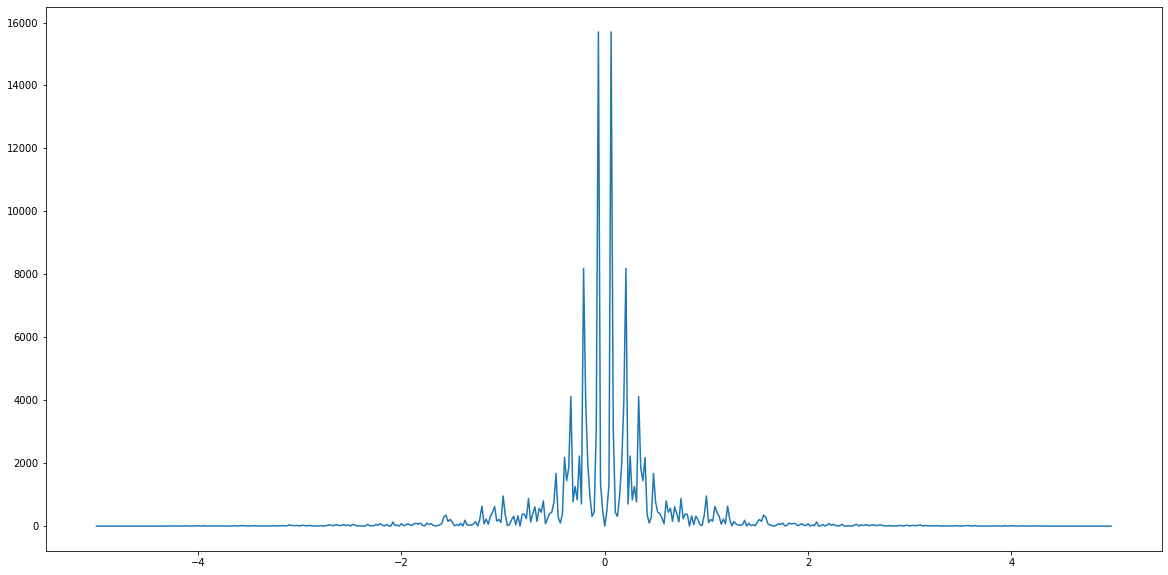

In [14]:
ps = np.abs(np.fft.fft(data))**2

time_step = 1 / 10
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])

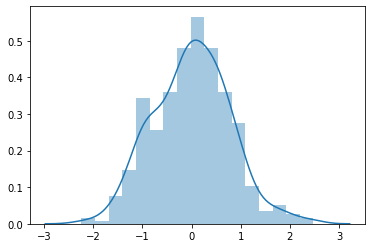

In [8]:
sns.distplot(data_sst[:,1000])

In [10]:
st.kstest(data_sst[:,10],"norm")

KstestResult(statistic=0.046070850565649114, pvalue=0.2522788648205505)

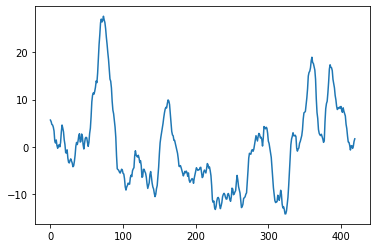

In [10]:
plt.plot(ts[:,2])

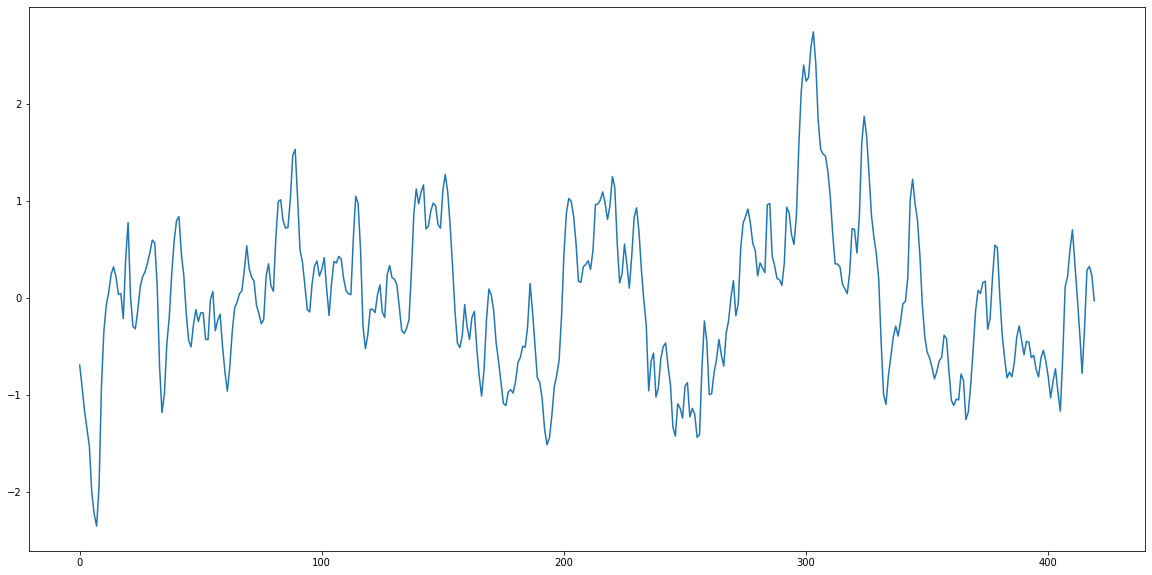

In [15]:
plt.plot(data_sst[:,1])

In [51]:
#sst = Data('../../../nc/soilw.mon.mean.v2.nc',"soilw",temporal_limits, missing_value= 0)
sst = Data('../../../nc/sst.mnmean.nc',"sst",temporal_limits, missing_value= -9.96921e+36)
sst = Data('../../../nc/GPCC_half.nc',"precip",temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_list = sst.get_lon_list()
lat_list = sst.get_lat_list()
lon = sst.get_lon()
lat = sst.get_lat()


#lons = np.arange(lon[0],lon[-1],2)
#lats = np.arange(lat[0],lat[-1],-2)

#index = []
#for i in range(len(lon_list)):
#    if (lon_list[i] in lons) and (lat_list[i] in lats):
#        index.append(i)

#result = result[:,index]
#lat_list = np.array(lat_list)[index]
#lon_list = np.array(lon_list)[index]



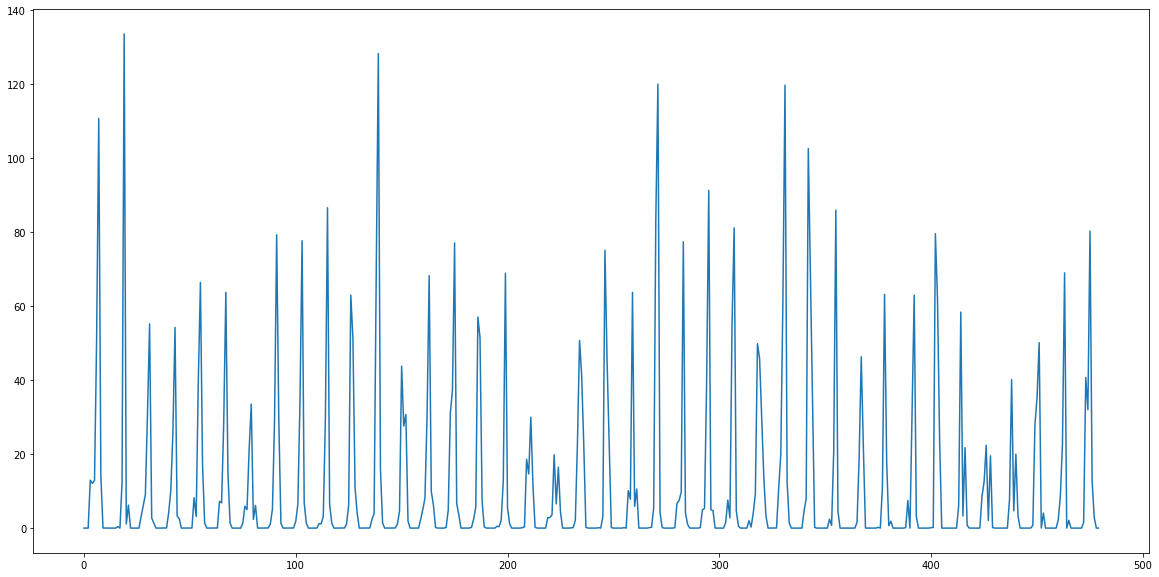

In [52]:
plt.plot(result[:,4000])

In [53]:
x = result[:,4000]

In [54]:
w = np.fft.fft(x)
freqs = np.fft.fftfreq(len(x))

for coef,freq in zip(w,freqs):
    if coef:
        print('{} * exp(2 pi i t * {})'.format(coef,freq))

[12.94999981+0.j] * exp(2 pi i t * 0.00625)
[12.07999992+0.j] * exp(2 pi i t * 0.008333333333333333)
[12.93000031+0.j] * exp(2 pi i t * 0.010416666666666666)
[51.45000076+0.j] * exp(2 pi i t * 0.0125)
[110.77999878+0.j] * exp(2 pi i t * 0.014583333333333334)
[14.09000015+0.j] * exp(2 pi i t * 0.016666666666666666)
[0.03+0.j] * exp(2 pi i t * 0.01875)
[0.38999999+0.j] * exp(2 pi i t * 0.03333333333333333)
[12.32999992+0.j] * exp(2 pi i t * 0.0375)
[133.6499939+0.j] * exp(2 pi i t * 0.03958333333333333)
[1.11000001+0.j] * exp(2 pi i t * 0.041666666666666664)
[6.21000004+0.j] * exp(2 pi i t * 0.04375)
[3.13000011+0.j] * exp(2 pi i t * 0.05625)
[6.03999996+0.j] * exp(2 pi i t * 0.058333333333333334)
[9.02000046+0.j] * exp(2 pi i t * 0.06041666666666667)
[30.76000023+0.j] * exp(2 pi i t * 0.0625)
[55.20999908+0.j] * exp(2 pi i t * 0.06458333333333333)
[2.73000002+0.j] * exp(2 pi i t * 0.06666666666666667)
[1.37+0.j] * exp(2 pi i t * 0.06875)
[0.03+0.j] * exp(2 pi i t * 0.08125)
[4.09000015+

In [55]:
from scipy import fftpack, signal
f_s = 1000
X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x))* f_s

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, 'Frequency Domain (Spectrum) Magnitude')

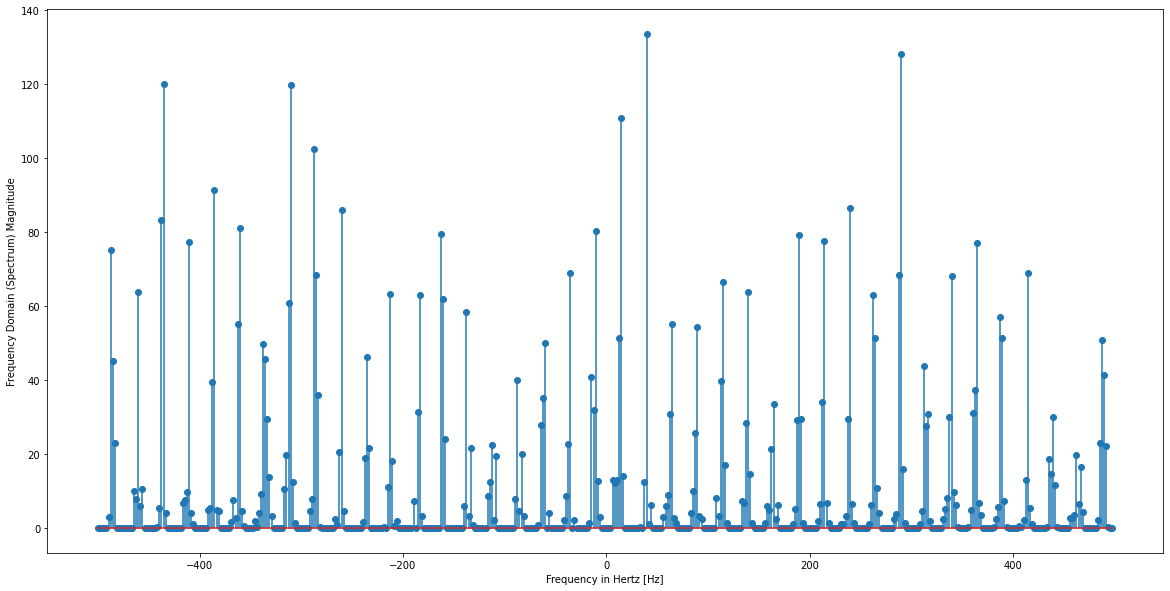

In [56]:
fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')

In [57]:
from scipy.fftpack import fft
 
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

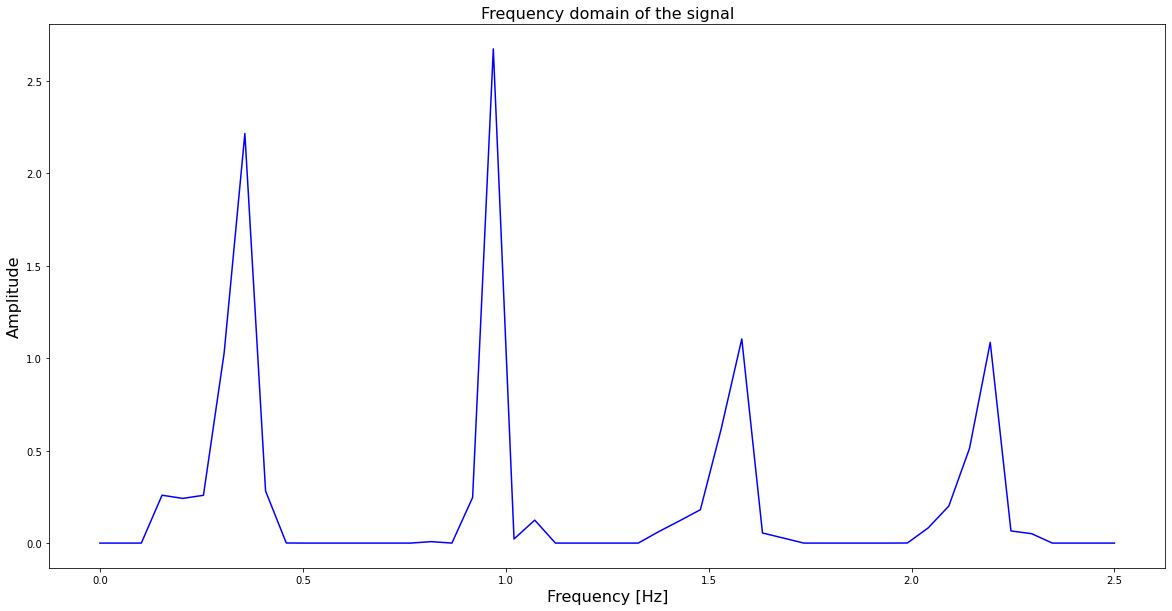

In [70]:
x = result[:,4000]
 
t_n = 20
N = 100
T = t_n / N
f_s = 1/T
 
f_values, fft_values = get_fft_values(x, T, N, f_s)
 
plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

In [71]:
T

0.2

In [74]:
np.squeeze(x)

matrix([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2950e+01, 1.2080e+01,
         1.2930e+01, 5.1450e+01, 1.1078e+02, 1.4090e+01, 3.0000e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.9000e-01, 0.0000e+00, 1.2330e+01, 1.3365e+02,
         1.1100e+00, 6.2100e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 3.1300e+00, 6.0400e+00, 9.0200e+00,
         3.0760e+01, 5.5210e+01, 2.7300e+00, 1.3700e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e-02,
         4.0900e+00, 1.0030e+01, 2.5640e+01, 5.4280e+01, 3.2900e+00,
         2.5400e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.0000e-02, 8.2000e+00, 3.1400e+00, 3.9760e+01,
         6.6450e+01, 1.7010e+01, 1.3700e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e-02, 7.2300e+00,
         6.8200e+00, 2.8470e+01, 6.3770e+01, 1.4680e+01, 1.3700e+00,
         0.0000e+00, 0.0000e+00, 0